In [1]:
import pandas as pd
import os
import sys
import metrics
import model_pipeline
import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import joblib

# read and prep data

In [2]:
X, y = utils.prep_playlist_df()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=0, stratify=y, shuffle=True
)

In [4]:
print(X_train.shape, X_test.shape)

(1571, 14) (846, 14)


#  Random forest Pipeline

In [6]:
pipeline = model_pipeline.make_random_forest_pipeline(X)

In [7]:
pipeline

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artist_names',
                                                   'track_names'])])),
                ('sampler', RandomOverSampler()),
                ('classifier', RandomForestClassifier())])

In [8]:
model = pipeline.fit(X_train, y_train)

In [9]:
model.score(X_test, y_test)

0.36524822695035464

In [23]:
y_pred = model.predict(X_test)

In [24]:
print(f"f1: {metrics.f1(y_test, y_pred):.3f}")

f1: 0.300


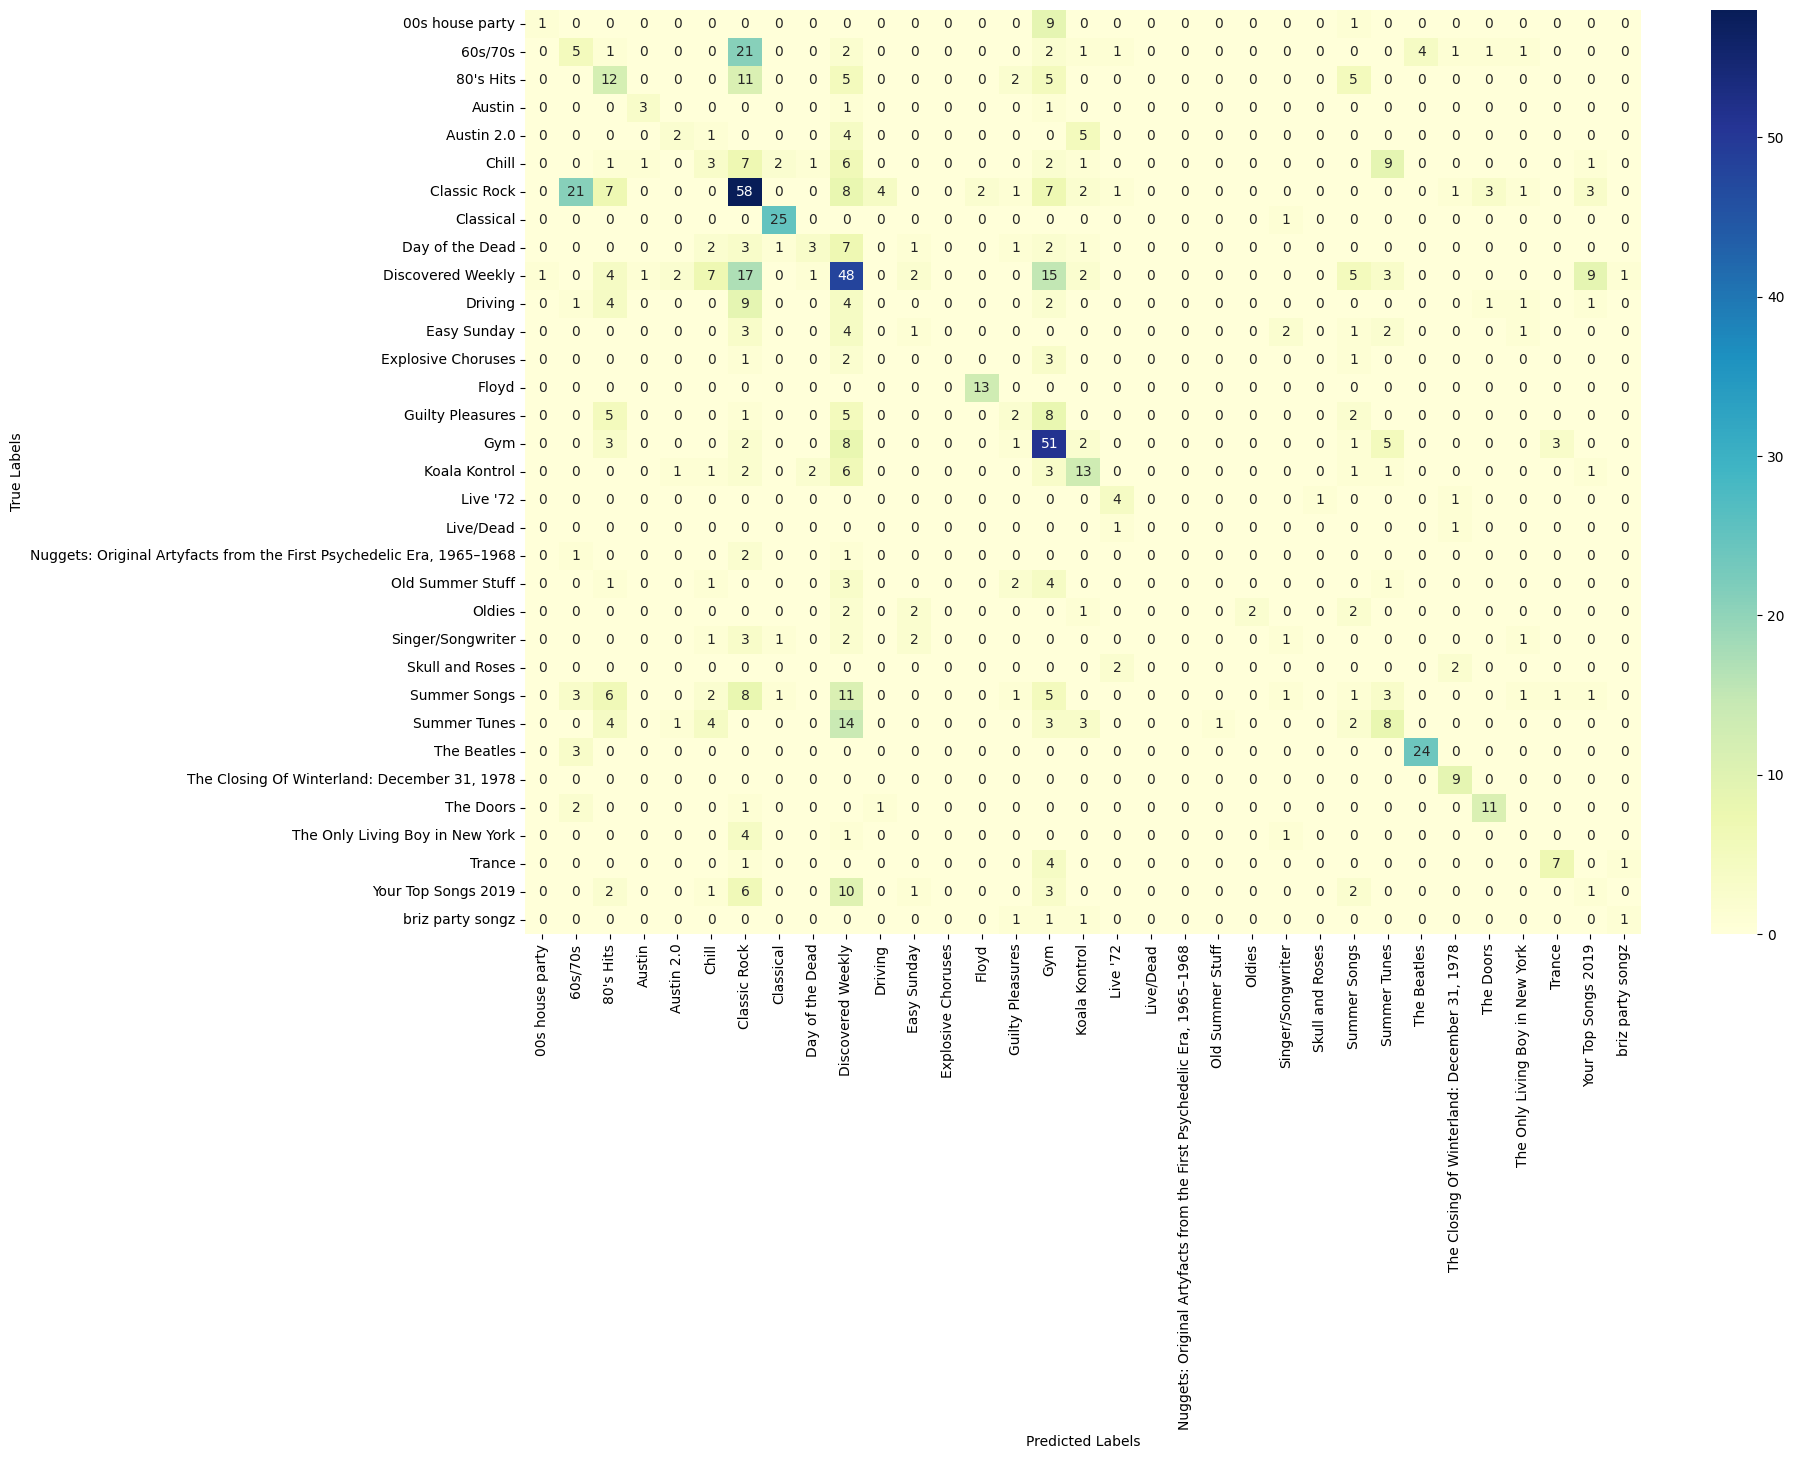

In [25]:
metrics.confusion_matrix(y_test, y_pred)

# Classifier comparison

First I'm comparing a few algorithms to see which perform best with some basic hyperparameter tuning, then I'll take the best models for further refinement. 


In [5]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [6]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [7]:
pipeline = model_pipeline.make_model_pipeline(X)

In [8]:
pipeline

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artist_names'])])),
                ('sampler', RandomOverSampler()), ('clf', ClfSwitcher())])

In [9]:
parameters = [
    {
        "clf__estimator": [LogisticRegression(max_iter=1000)],
        "clf__estimator__C": [10, 1.0, 0.1, 0.01],
    },
    {
        "clf__estimator": [xgb.XGBClassifier()],
        "clf__estimator__max_depth": [6, 10],
        "clf__estimator__learning_rate": [0.1, 0.05],
    },
    {
        "clf__estimator": [MLPClassifier()],
        "clf__estimator__hidden_layer_sizes": [(50, 50, 50), (50, 100, 50)],
        "clf__estimator__alpha": [0.0001],
        "clf__estimator__learning_rate": ["adaptive"],
    },
]

In [13]:
gscv = GridSearchCV(
    pipeline,
    parameters,
    scoring="f1_micro",
    cv=4,
    return_train_score=False,
    verbose=3,
    refit=True,
)
gscv.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END clf__estimator=LogisticRegression(max_iter=1000);, score=0.331 total time=   3.4s
[CV 2/4] END clf__estimator=LogisticRegression(max_iter=1000);, score=0.331 total time=   2.6s
[CV 3/4] END clf__estimator=LogisticRegression(max_iter=1000);, score=0.369 total time=   2.2s
[CV 4/4] END clf__estimator=LogisticRegression(max_iter=1000);, score=0.378 total time=   3.2s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'key',
                                                                          'loudness',
                                                                          'mode',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_ms',
                                                                          'time_signature']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['artist_names'])])),
                                       ('sampler', RandomOverSampler()),
                                       ('clf', ClfSwitcher())]),
             param_grid=[{'clf__estimator': [LogisticRegression(max_iter=1000)]}],
             scoring='f1_micro', verbose=3)

In [14]:
gscv.best_params_

{'clf__estimator': LogisticRegression(max_iter=1000)}

In [15]:
joblib.dump(gscv.best_estimator_, "classifier_model.pkl")

['classifier_model.pkl']

In [16]:
print(f"best f1: {gscv.best_score_:.3f}")

best f1: 0.352


In [17]:
y_pred = gscv.predict(X_test)

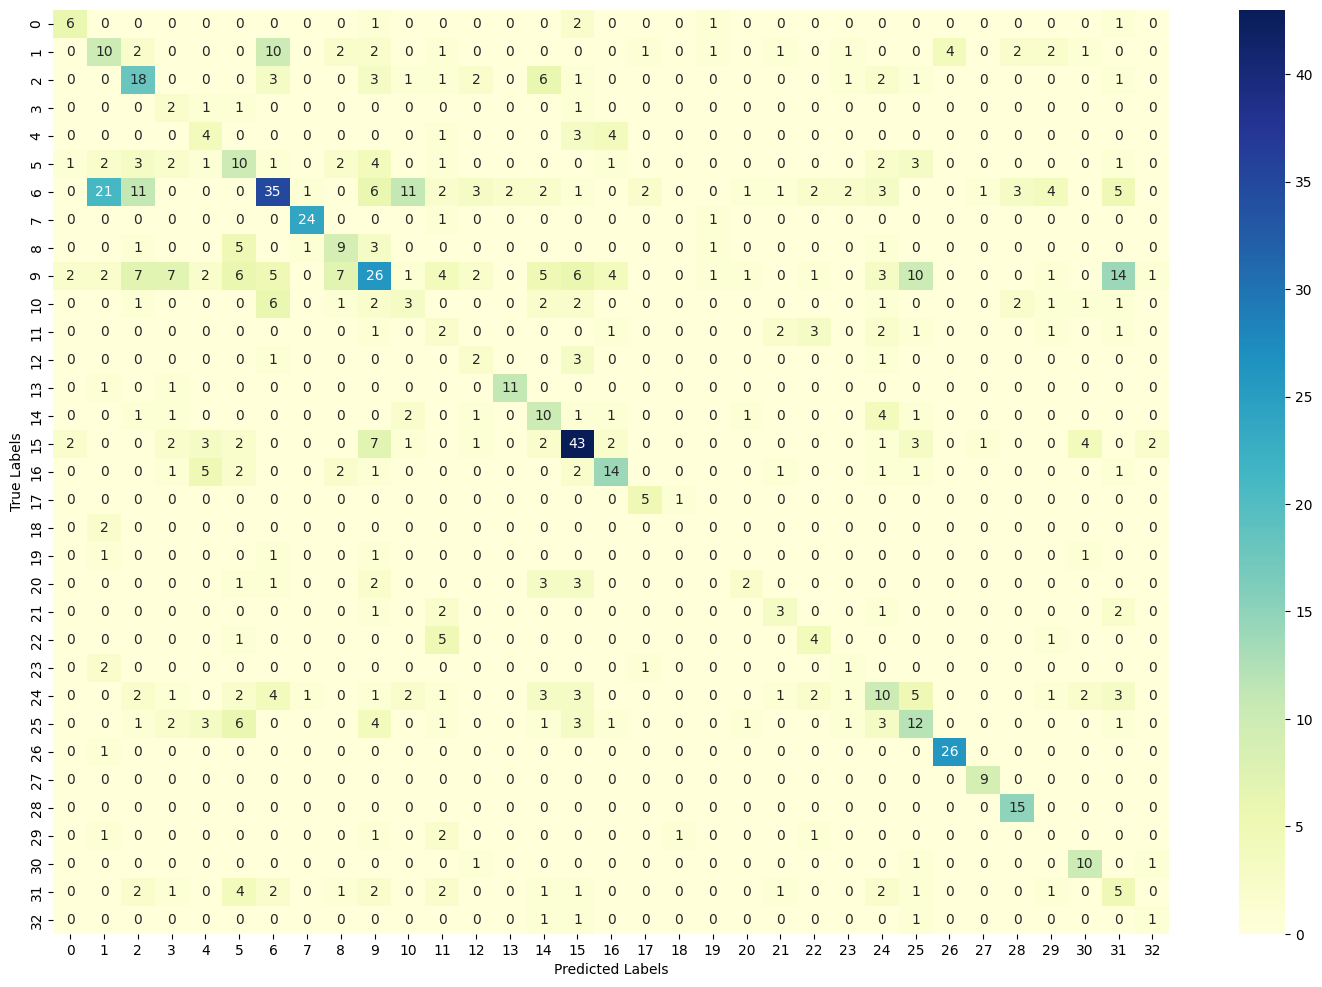

In [18]:
metrics.confusion_matrix(y_test, y_pred)

In [19]:
utils.invert_label_encoding(le)

{0: '00s house party',
 1: '60s/70s',
 2: "80's Hits",
 3: 'Austin',
 4: 'Austin 2.0',
 5: 'Chill',
 6: 'Classic Rock',
 7: 'Classical',
 8: 'Day of the Dead',
 9: 'Discovered Weekly',
 10: 'Driving',
 11: 'Easy Sunday',
 12: 'Explosive Choruses',
 13: 'Floyd',
 14: 'Guilty Pleasures',
 15: 'Gym',
 16: 'Koala Kontrol',
 17: "Live '72",
 18: 'Live/Dead',
 19: 'Nuggets: Original Artyfacts from the First Psychedelic Era, 1965–1968',
 20: 'Old Summer Stuff',
 21: 'Oldies',
 22: 'Singer/Songwriter',
 23: 'Skull and Roses',
 24: 'Summer Songs',
 25: 'Summer Tunes',
 26: 'The Beatles',
 27: 'The Closing Of Winterland: December 31, 1978',
 28: 'The Doors',
 29: 'The Only Living Boy in New York',
 30: 'Trance',
 31: 'Your Top Songs 2019',
 32: 'briz party songz'}